# Bayesian Rating Adjustment

This notebook implements an **Empirical Bayes** approach to adjust the average user ratings for each place, accounting for varying review counts. By combining each place’s observed mean rating with a global prior, we obtain more reliable “posterior” ratings that shrink extreme values when sample sizes are small.

**Objectives:**
1. Load aggregated ratings data (`ratings_clean.csv`) and individual review data (`comments_clean.csv`).
2. Compute the global prior mean (μ₀) of all ratings.
3. Estimate the within-review variance (σ²) and the between-place variance (τ²).
4. Calculate the **shrinkage factor** for each place:  
   $$\lambda_i = \frac{\tau^2}{\tau^2 + \sigma^2 / n_i}$$  
   where \($n_i$\) is the number of reviews for place *i*.
5. Derive the **Bayesian-adjusted rating**:  
   $$\text{Rating}_\text{Bayes} = \lambda_i \times \text{Rating}_i + (1 - \lambda_i) \times \mu_0$$
6. Inspect the top-ranked places by adjusted rating and export results for further analysis.

This method mitigates the impact of small sample sizes, ensuring that places with very few reviews are “pulled” toward the global mean, while places with many reviews remain close to their observed average.

In [43]:
# Importar pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

In [44]:
# Carregar os dados agregados de ratings e o CSV de comentários (para estimar variâncias)
ratings_df = pd.read_csv("C:/Users/Fernanda Costa/OneDrive - Universidade de Aveiro/Desktop/seminar_project/3_exploratory_analysis/ratings_geocoded.csv")        # contém colunas: id_unico, Rating, Total_Reviews, etc.
comments_df = pd.read_csv("C:/Users/Fernanda Costa/OneDrive - Universidade de Aveiro/Desktop/seminar_project/2_pre_processing_NLP/comments_clean.csv")      # contém colunas: Rating (por comentário)

In [45]:
# Calcular média global de ratings (prior mean μ₀)
mu_global = ratings_df["Rating"].mean()

In [46]:
# Estimar variância dos ratings individuais (σ²) a partir de todos os comentários disponíveis
sigma2 = comments_df["Rating"].var()

In [47]:
# Estimar variância entre locais (τ²), ajustando por variação de amostragem
local_means = ratings_df["Rating"]
n_i = ratings_df["Total_Reviews"].replace(0, np.nan)   # evita divisão por zero
tau2 = max(0, local_means.var() - (sigma2 / n_i).mean())

In [48]:
# Calcular shrinkage (com NaN onde Total_Reviews = 0)
ratings_df["shrinkage"] = tau2 / (tau2 + sigma2 / n_i)

# Inicializar Rating_Bayes com a média global (para casos com 0 reviews)
ratings_df["Rating_Bayes"] = mu_global

# Atualizar apenas os casos válidos
mask_valid = ratings_df["shrinkage"].notna()
ratings_df.loc[mask_valid, "Rating_Bayes"] = (
    ratings_df.loc[mask_valid, "shrinkage"] * ratings_df.loc[mask_valid, "Rating"]
  + (1 - ratings_df.loc[mask_valid, "shrinkage"]) * mu_global
)

In [49]:
# Inspecionar resultados
print("Global mean (μ₀):", round(mu_global, 3))
print("Estimated σ²:", round(sigma2, 3))
print("Estimated τ²:", round(tau2, 3))
print("\nTop 10 locais por Rating_Bayes:")
print(ratings_df
      .sort_values("Rating_Bayes", ascending=False)
      [["id_unico","Nome","Rating","Total_Reviews","Rating_Bayes"]]
      .head(10)
)

Global mean (μ₀): 4.449
Estimated σ²: 1.219
Estimated τ²: 0.089

Top 10 locais por Rating_Bayes:
     id_unico                         Nome  Rating  Total_Reviews  \
116  cfe52afc              Serra Da Freita     4.9            398   
184  134bb7d9      Be Happy Lodge & Brunch     4.9            275   
194  fd2c7e06           Maceda Surf Hostel     4.9            161   
150  0df624aa  Casta Wine Bar & Restaurant     4.9            154   
153  5395f923           Sabores da Fatinha     4.9            152   
534  5b643d50                    Chef Mamã     4.9            150   
383  899a5e28                   Goldnature     4.9            137   
543  5ce416a1               La Bocca Dolce     4.9            132   
198  99c06514         Watermark Surf House     4.9            115   
394  3c3f901b                       O´LOPO     5.0             33   

     Rating_Bayes  
116      4.884964  
184      4.878558  
194      4.864568  
150      4.863089  
153      4.862643  
534      4.862187  
383

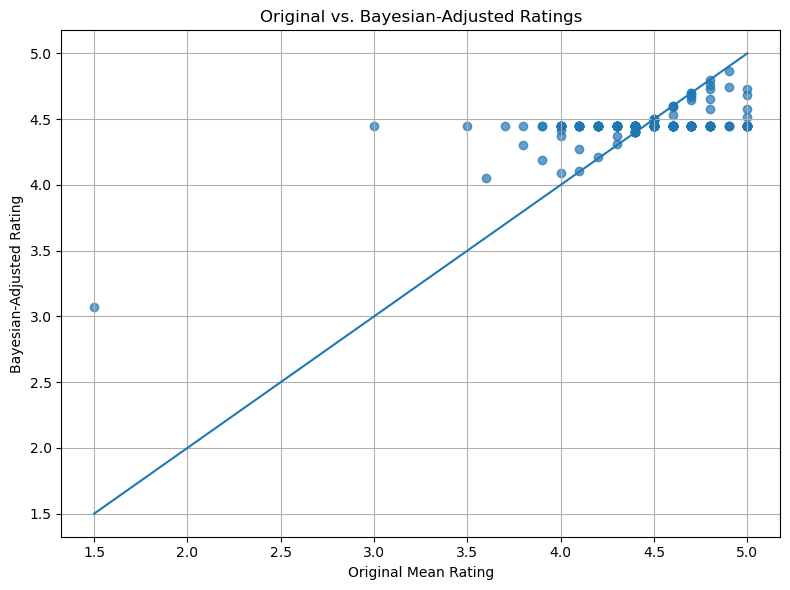

In [50]:
# For clarity, sample a subset of 200 points
sample_df = ratings_df.sample(n=200, random_state=42)

# Prepare plot
plt.figure(figsize=(8, 6))
plt.scatter(sample_df['Rating'], sample_df['Rating_Bayes'], alpha=0.7)
min_val = min(sample_df['Rating'].min(), sample_df['Rating_Bayes'].min())
max_val = max(sample_df['Rating'].max(), sample_df['Rating_Bayes'].max())

# Identity line (no adjustment)
plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel('Original Mean Rating')
plt.ylabel('Bayesian-Adjusted Rating')
plt.title('Original vs. Bayesian-Adjusted Ratings')
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
comments_df.columns

Index(['Cidade', 'Categoria', 'Nome_Local', 'Autor', 'Texto', 'Data', 'Rating',
       'Idioma', 'Data_Convertida', 'translated_text', 'Texto_Normalizado',
       'Texto_Lematizado', 'Polaridade', 'Polaridade_Média'],
      dtype='object')

## Appendix: Doctor Who–Style Bayesian Prior vs Posterior Plot

This illustration shows how prior knowledge (Beta distribution) is updated by new data to form the posterior distribution.

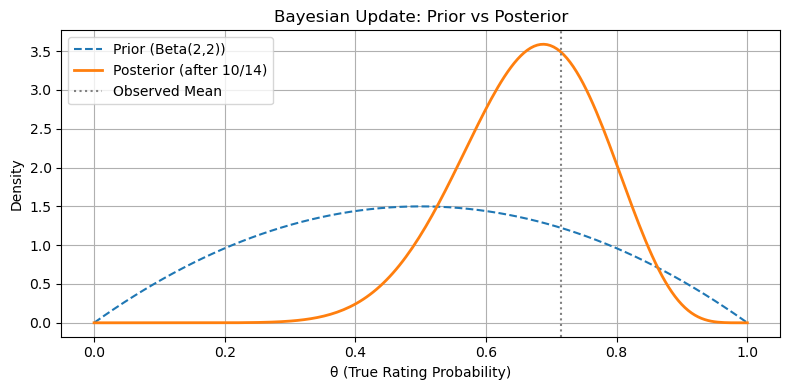

In [52]:
# Define prior (α₀, β₀)
a0, b0 = 2, 2

# Example observation: 10 out of 14 reviews are positive
y, n = 10, 14

# Posterior parameters
a1 = a0 + y
b1 = b0 + n - y

# θ grid and densities
θ = np.linspace(0, 1, 200)
plt.figure(figsize=(8, 4))
plt.plot(θ, beta.pdf(θ, a0, b0), label="Prior (Beta(2,2))", linestyle="--")
plt.plot(θ, beta.pdf(θ, a1, b1), label="Posterior (after 10/14)", linewidth=2)
plt.axvline(x=y/n, color="gray", linestyle=":", label="Observed Mean")
plt.xlabel("θ (True Rating Probability)")
plt.ylabel("Density")
plt.title("Bayesian Update: Prior vs Posterior")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
# Guardar o resultado num CSV
ratings_df.to_csv("ratings_with_bayesian_adjustment.csv", index=False)

## Interpretation
- The prior (Beta(2,2)) represents a neutral belief about rating probability before data.
- After observing 10 out of 14 positive outcomes (e.g. "good reviews"), the posterior becomes more peaked around the observed mean.
- This illustrates the effect of combining prior belief with new data.

## Application to IGATP Rating Adjustment
The same principle is applied to compute `Rating_Bayes` in the IGATP, using the Bayesian average:

`Rating_Bayes = (μ * shrinkage + Σ rating_i) / (shrinkage + N)`

where:
- μ is the global average rating
- N is the number of reviews for that location
- `shrinkage` is the strength of the prior

This allows fairer comparisons between locations with few and many reviews.

In [54]:
ratings_df.head()

,Cidade,Categoria,Nome,Rating,Endereço,Tipos,Latitude,Longitude,Total_Reviews,id_unico,Grupo_Tematico,Locais_Semelhantes_Perto,Latitude_Nova,Longitude_Nova,Endereço_Limpo,shrinkage,Rating_Bayes
0,Arouca,restaurant,Tasquinha da Quinta,4.6,"R. 1º de Maio 3, 4540-121 Arouca, Portugal","restaurant, food, point_of_interest, establish...",40.929109,-8.245191,2154,d111a3c6,Serviços,6.0,40.921484,-8.365184,"R. 1º de Maio 3, 4540-121 Arouca, Portugal",0.993672,4.599043
1,Arouca,restaurant,Tasquinho do Parque,4.5,"R. Dom Afonso Henriques 57 4540, Arouca, Portugal","restaurant, food, point_of_interest, establish...",40.927645,-8.248854,203,066473c6,Serviços,2.0,40.926936,-8.248950,"R. Dom Afonso Henriques 57 4540, Arouca, Portugal",0.936705,4.496752
2,Arouca,restaurant,Varandinha,4.4,"Av. Reinaldo Noronha 39, 4540-181 Arouca, Port...","restaurant, food, point_of_interest, establish...",40.934069,-8.241372,721,dc4ee328,Serviços,1.0,40.935438,-8.244661,"Av. Reinaldo Noronha 39, 4540-181 Arouca, Port...",0.981330,4.400909
3,Arouca,restaurant,Café Arouquense,4.3,"Av. 25 de Abril, 4540-102 Arouca, Portugal","cafe, restaurant, food, point_of_interest, est...",40.928469,-8.245599,901,47e0eea2,Serviços,6.0,40.928498,-8.248323,"Av. 25 de Abril, 4540-102 Arouca, Portugal",0.985004,4.302230
4,Arouca,restaurant,Quinta D'Além da Ponte,4.5,"Lugar do, 4540-606 Arouca, Portugal","restaurant, food, point_of_interest, establish...",40.939060,-8.341836,423,61113e19,Serviços,0.0,40.949164,-8.395749,"Lugar do, 4540-606 Arouca, Portugal",0.968591,4.498388


In [55]:
ratings_df['Rating_Bayes'].isnull().sum()

0